In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
samples = data['text'].values

# 원본 텍스트를 케라스에서 사용할 수 있도록 넘파이 배열로 변환하는 방법.
## 1. 단어 원-핫 인코딩
## 2. 단어 임베딩

# 단어 수준 원-핫 인코딩(one-hot incoding)

In [4]:
token_index = {} # samples에 있는 모든 토큰의 인덱스

for sample in samples:
    for word in sample.split(): # 단어 단위로 분할
        if word not in token_index: # 단어 별 고유 인덱스 할당
            token_index[word] = len(token_index) + 1
            # 인덱스 0은 사용안함

max_length = 10 # 한 문장 당 최대 토큰 개수
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1)) # 결과 저장 배열

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        
results.shape # results 크기 = 문장 개수x(max_length)x전체 단어 개수

(7613, 10, 31925)

## 케라스 이용
* 특수 문자를 제거하거나 빈도가 높은 N개의 단어만을 선택하는 등 여러 가지 중요한 기능 제공

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000) # 가장 빈도가 높은 1,000개의 단어만 선택하도록 Tokenizer 객체 만들기
tokenizer.fit_on_texts(samples)# 단어 인덱스 구축.
sequences = tokenizer.texts_to_sequences(samples) # 문자열을 정수 인덱스의 리스트로 변환.

# print('samples', samples[:5], sep='\n')
print('samples to word index list(sequences)', sequences[:5], sep='\n')

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary') # 원-핫 이진 벡터 표현
print('one hot results', one_hot_results[:5])

word_index = tokenizer.word_index # 계산된 단어 인덱스
# print('word index list', word_index)
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


samples to word index list(sequences)
[[119, 24, 4, 868, 8, 21, 263, 138, 89, 40], [189, 45, 229, 799], [40, 7, 6, 24, 136, 20, 39, 441, 256, 57, 6, 714, 24], [835, 59, 256, 6, 96], [34, 100, 21, 320, 22, 30, 271, 22, 69, 5, 187]]
one hot results [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Found 22700 unique tokens.


# 문자 수준 원-핫 인코딩

In [6]:
import string

characters = string.printable  # 출력 가능한 모든 아스키(ASCII) 문자
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.
        
results.shape

(7613, 50, 101)

# 단어 수준의 원-핫 해싱(one-hot hashing)
* 토큰의 수가 너무 클 때 사용
* 단어의 인덱스를 딕셔너리에 저장하는 대신, 간단한 해싱 함수를 사용하여 고정된 크기의 벡터로 변환.
* 주의할 점: 해시 충돌(hash collision). 두 개의 단어가 같은 해시를 만들지 않도록 주의.

In [7]:
dimensionality = 1000 # 단어를 크기가 1,000인 벡터로 저장. 1,000개(또는 그이상)의 단어가 있다면 해싱 충돌이 늘어나고 인코딩의 정확도가 감소될 것,,

max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality # 단어를 해싱하여 0과 1,000 사이의 랜덤한 정수 인덱스로 변환
        results[i, j, index] = 1.
        
results.shape

(7613, 10, 1000)

원-핫 인코딩으로 만든 벡터는 희소하고(대부분 값이 0) 고차원임(단어의 수와 차원이 같음).

# Embedding
* 텍스트 정보를 적은 차원에 저장(단어 밀집 벡터).
* 원-핫 인코딩처럼 직접 벡터를 생성하는 것이 아닌, 데이터로부터 학습하여 얻음.
* 단어 임베딩이란 단어 간의 특정 의미 관계내는 단어 벡터 간의 연결을 나타냄.
* 어떤 문제를 해결하느냐에 따라 새로운 임베딩을 학습해야 함.
  (영어로 된 영화 리뷰 감성 분석 모델을 위한 단어 임베딩 공간은 한국어로 된 영화 리뷰 감성 분석 모델을 위한 단어 임베딩 공간과 다를 것.)
* 임베딩 층의 가중치를 학습.
  * 임베딩 층은 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리 같은 역할.
  * 정수를 입력으로 받아 내부 딕셔너리에서 정수와 연관된 벡터를 찾아 반환.
  * 단어 인덱스 --> embedding layer --> 연관된 단어 벡터
  * 여기서 말하는 가중치는 토큰 벡터 매핑을 위한 내부 딕셔너리를 말함.
  * 가중치는 초기에 신경망처럼 랜덤하게 초기화되어 있으며 역전파를 통해 점차 조정되어 이어지는 모델이 사용할 수 있도록 임베딩 공간 구성.
  * 훈련이 끝나면 임베딩 공간은 특정 문제에 특화된 구조를 가지게 됨.

In [8]:
from keras.layers import Embedding

# 임베딩 층은 적어도 2개의 매개변수 필요. (max token, embedding_dimensionality)
embedding_layer = Embedding(1000,64)
# 가능한 토큰의 개수 1000 = 단어 인덱스 최대값+1
# 임베딩 차원 64
# 가중치 크기는 1000x64, 단어 인덱스는 1~999 사이.

In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

max_len = 100 # 사용할 텍스트 길이, sequence_length
max_features = 10000 # 특성으로 사용할 단어 수, 가장 빈도 높은 1만개 단어만 사용.

sample_data = data[['text','target']]
idx = sample_data.index
x_train_idx, x_val_idx, y_train, y_val = train_test_split(idx, sample_data['target'].values, test_size=0.33, random_state=0)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(sample_data['text'])
sequence = tokenizer.texts_to_sequences(sample_data['text']) 

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

# 임베딩 층 입력 = (samples, sequence_length)인 2D 정수 텐서
# (samples, max_len) 크기의 2D 정수 텐서 변경
token_data = pad_sequences(sequence, maxlen=max_len)

x_train = token_data[x_train_idx]
x_val = token_data[x_val_idx]

x_train.shape, x_val.shape, y_train.shape, y_val.shape

22700개의 고유한 토큰을 찾았습니다.


((5100, 100), (2513, 100), (5100,), (2513,))

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()

# input_length = 입력 sequence 길이
# 임베딩 층 출력 = (samples, sequence_length, embedding_dimensionality)인 3D 실수 텐서(임베딩 시퀀스)
# 여기서 출력 크기는 (samples, max_len, 8)
model.add(Embedding(max_features, 8, input_length=max_len))

# 3D 임베딩 텐서를 (samples, max_len * 8) 크기의 2D 텐서로 펼침.
model.add(Flatten())

# 분류기 추가.
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________
Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 1s 176us/step - loss: 0.6711 - acc: 0.5796 - val_loss: 0.6389 - val_acc: 0.6486
Epoch 2/10
5100/5100 [==============================] - 0s 93us/step - loss: 0.6038 - acc: 0.7125 - val_loss: 0.5685 - val_acc: 0.7402
Epoch 3/10
5100/5100 [==============================] - 0s 88

* 약 79% 정도의 검증 정확도.
* 임베딩 시퀀스를 펼치고 하나의 Dense 층을 훈련했으므로 입력 시퀀스에 있는 각 단어를 독립적 다룸. 단어 사이의 관계나 문장의 구조를 고려하지 않음.
* 각 시퀀스 전체를 고려한 특성을 학습하기 위해서는 임베딩 층 위에 순환 층이나 1D 합성곱 층을 추가해야 함.

# 사전 훈련된 단어 임베딩 사용하기

* GloVe 임베딩 전처리

In [11]:
glove_dir = '../input/glove-global-vectors-for-word-representation/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8") # 100차원 임베딩 벡터 파일
# .txt 파일 파싱
for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs # 단어와 이에 상응하는 벡터 표현(숫자 벡터)를 매핑하는 인덱스 생성.
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [12]:
# word_index.items()

* 임베딩 행렬 준비

In [13]:
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items(): # word_index: bow
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            # 임베딩 행렬의 인덱스 i = 단어 인덱스(고유 번호)
            # 행렬 i 원소 = 단어 i에 상응하는 embedding_dim 차원의 벡터

* 모델 정의

In [14]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


* 모델에 GloVe 임베딩 로드

In [15]:
# 모델의 첫 번째 층인 Embedding 층에 준비된 GloVe 행렬을 로드
model.layers[0].set_weights([embedding_matrix])

# trainable 속성 동결, 훈련하는 동안 사전 훈련된 부분의 업데이트 방지.
# 학습하는 동안 랜덤하게 초기화된 다른 층으로부터 대량의 그래디언트 업데이트가 발생하면 이미 학습된 특성을 잃어버리기 때문,
model.layers[0].trainable = False

* 모델 훈련 및 평가

f1_score

In [16]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc',f1score])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 5100 samples, validate on 2513 samples
Epoch 1/10
5100/5100 [==============================] - 1s 273us/step - loss: 0.5247 - acc: 0.7492 - f1score: 0.6823 - val_loss: 0.5180 - val_acc: 0.7521 - val_f1score: 0.7200
Epoch 2/10
5100/5100 [==============================] - 1s 196us/step - loss: 0.4146 - acc: 0.8149 - f1score: 0.7690 - val_loss: 0.4803 - val_acc: 0.7895 - val_f1score: 0.6894
Epoch 3/10
5100/5100 [==============================] - 1s 183us/step - loss: 0.3565 - acc: 0.8437 - f1score: 0.8043 - val_loss: 0.5133 - val_acc: 0.7855 - val_f1score: 0.6881
Epoch 4/10
5100/5100 [==============================] - 1s 178us/step - loss: 0.2996 - acc: 0.8706 - f1score: 0.8384 - val_loss: 0.5181 - val_acc: 0.7803 - val_f1score: 0.7040
Epoch 5/10
5100/5100 [==============================] - 1s 186us/step - loss: 0.2559 - acc: 0.8975 - f1score: 0.8746 - val_loss: 0.6173 - val_acc: 0.7573 - val_f1score: 0.7264
Epoch 6/10
5100/5100 [==============================] - 1s 185us/step - 

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

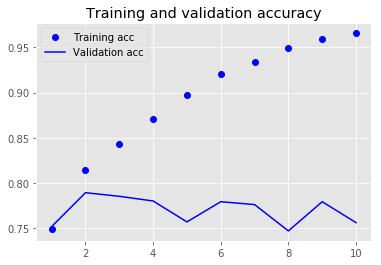

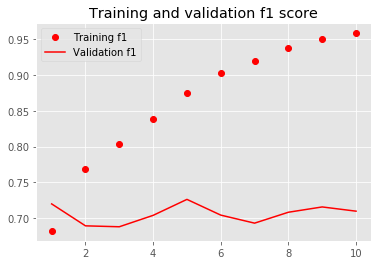

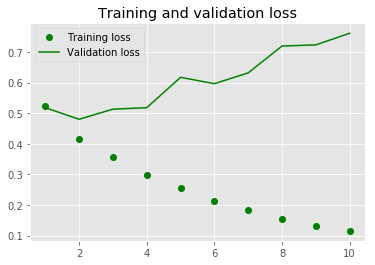

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
fl = history.history['f1score']
val_fl = history.history['val_f1score']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, fl, 'ro', label='Training f1')
plt.plot(epochs, val_fl, 'r', label='Validation f1')
plt.title('Training and validation f1 score')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# 테스트 데이터 tokenization & submission

In [20]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(test_data['text'])
sequence = tokenizer.texts_to_sequences(test_data['text']) 

x_test = pad_sequences(sequence, maxlen=max_len)

x_test.shape

(3263, 100)

In [21]:
model.load_weights('pre_trained_glove_model.h5')
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

In [22]:
sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sub['target'] = y_pred
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,0
